In [1]:
import pandas as pd

In [2]:
X = pd.read_parquet("./data/features_atc4.parquet")
y = pd.read_parquet("./data/labels.parquet")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from matplotlib import pyplot as plt

In [4]:
import torch

In [5]:
X["hour"] = X["intime"].dt.hour

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
categorical_features = [
    "gender",
    "hour"
]+X_train.columns[12:].tolist()

continuous_features = [
    "pain",
    "age",
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp"
]

In [8]:
features_preprocessing = ColumnTransformer([
    ("binary_encoder", OrdinalEncoder(), categorical_features),
    ("identity", StandardScaler(), continuous_features),
    ("missing", MissingIndicator(), continuous_features),
    ("nlp", Pipeline([
        ("cv", CountVectorizer(ngram_range=(1,1), max_features=200)),
        ("tf-idf", TfidfTransformer())
    ]), "chiefcomplaint"),
])

features_preprocessing_without_nlp = ColumnTransformer([
    ("binary_encoder", OrdinalEncoder(), categorical_features),
    ("identity", StandardScaler(), continuous_features),
    ("missing", MissingIndicator(), continuous_features)
])

full_preprocessing = Pipeline([
    ("features", features_preprocessing_without_nlp),
    ("imputer", SimpleImputer())
])

pipeline = Pipeline([
    ("preprocessing", full_preprocessing),
    ("mlp", MLPClassifier(hidden_layer_sizes=(100,20), verbose=True, learning_rate_init=1e-3, batch_size=64, max_iter=100))
])

In [9]:
preprocesser = full_preprocessing.fit(X_train, y_train)

In [10]:
from transformers import BertTokenizer, BertModel

In [11]:
biobert_tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

In [12]:
X_train_preprocess = torch.tensor(preprocesser.transform(X_train), dtype=torch.float32)
X_train_tokens = biobert_tokenizer(X_train["chiefcomplaint"].tolist())["input_ids"]
y_train_preprocess = torch.tensor(y_train.iloc[:,1:].values, dtype=torch.float32)
X_test_preprocess = torch.tensor(preprocesser.transform(X_test), dtype=torch.float32)
X_test_tokens = biobert_tokenizer(X_test["chiefcomplaint"].tolist())["input_ids"]
y_test_preprocess = torch.tensor(y_test.iloc[:,1:].values, dtype=torch.float32)
X_train_tokens = [torch.tensor(x) for x in X_train_tokens]
X_test_tokens = [torch.tensor(x) for x in X_test_tokens]

In [ ]:
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torch
import operator

In [ ]:
class neural_net (nn.Module):
    def __init__(self, n_features, n_outputs):
        super().__init__()

        self.network = nn.Sequential(*[
            nn.Linear(n_features+768, 500),
            nn.BatchNorm1d(500),
            nn.LeakyReLU(0.1),
            nn.Linear(500, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, n_outputs),
            nn.Sigmoid()
        ])

        self.biobert_model = BertModel.from_pretrained("dmis-lab/biobert-v1.1").to("cuda:0")
        for x in self.biobert_model.parameters():
            x.requires_grad = False
            
        self.loss = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=5e-4)

    def forward(self, x):
        
        x_data = x[0]
        x_tokens = x[1]

        x_bert = torch.mean(self.biobert_model.embeddings.word_embeddings(x_tokens), axis=1)
        x = torch.concat([x_data, x_bert], axis=1)

        y_hat = self.network(x)

        return y_hat
    
    def fit(self, x, y):
        
        self.train()
        self.optimizer.zero_grad()

        y_hat = self.forward(x)

        loss = self.loss(y_hat, y)

        loss.backward()
        self.optimizer.step()

        return loss

    def predict(self, x):
        
        self.eval()
        
        with torch.no_grad():            
            y_hat = self.forward(x)

        return y_hat

In [ ]:
network = neural_net(X_train_preprocess.shape[1], y_train_preprocess.shape[1])
network = network.to("cuda:0")

In [ ]:
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
data_loader = DataLoader(range(X_train_preprocess.shape[0]), shuffle=True, batch_size=512)

In [ ]:
n_epochs = 100
n_epoch_print = 1
n_batch_print = 50

for i in range(n_epochs):

    losses = []

    j = 0
    for indices in data_loader:
        X_tensor = X_train_preprocess[indices,:].to("cuda:0")
        X_train_tokens_indices = list(operator.itemgetter(*indices)(X_train_tokens))
        X_train_tokens_indices = pad_sequence(X_train_tokens_indices, batch_first=True, padding_value=biobert_tokenizer("[PAD]")["input_ids"][1]).to("cuda:0")

        y_tensor = y_train_preprocess[indices,:].to("cuda:0")

        loss = network.fit((X_tensor, X_train_tokens_indices), y_tensor).detach().cpu().item()
        losses.append(loss)

        if j%n_batch_print == 0:
            print(np.array(losses).mean())
        
        j += 1

    if (i%n_epoch_print) == 0:
        mean_loss = np.array(losses).mean()
        print(f"Epoch {i} - loss : {mean_loss}")

0.35904401540756226
0.3628128885042549
0.3626623178892468
0.36212184619269894
Epoch 0 - loss : 0.36184037493754034
0.3660319149494171
0.35813640161315996
0.35807146732486894
0.3580603587667015
Epoch 1 - loss : 0.3582924585553664
0.3633681833744049
0.3539693438180602
0.3550527073554139
0.35535963062828163
Epoch 2 - loss : 0.3559726171855685
0.3667027950286865
0.35198344186981123
0.35242729667407363
0.3531943013105678
Epoch 3 - loss : 0.35359182267249384
0.3803612291812897


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, recall_score, precision_score

In [138]:
batch_size = 256

y_hats = []

for idx in range(0, X_test_preprocess.shape[0], batch_size):
    X_test_tensor = X_test_preprocess[idx:idx+batch_size].to("cuda:0")
    X_test_tokens_indices = X_test_tokens[idx:idx+batch_size]
    X_test_tokens_indices = pad_sequence(X_test_tokens_indices, batch_first=True, padding_value=biobert_tokenizer("[PAD]")["input_ids"][1]).to("cuda:0")

    y_hat_ = ((network.predict((X_test_tensor, X_test_tokens_indices)).detach().cpu()) >= 0.5)*1

    y_hats.append(y_hat_)

y_hat = torch.concat(y_hats, axis=0).numpy()
y_true = y_test_preprocess
titles = y_train.columns.tolist()[1:]

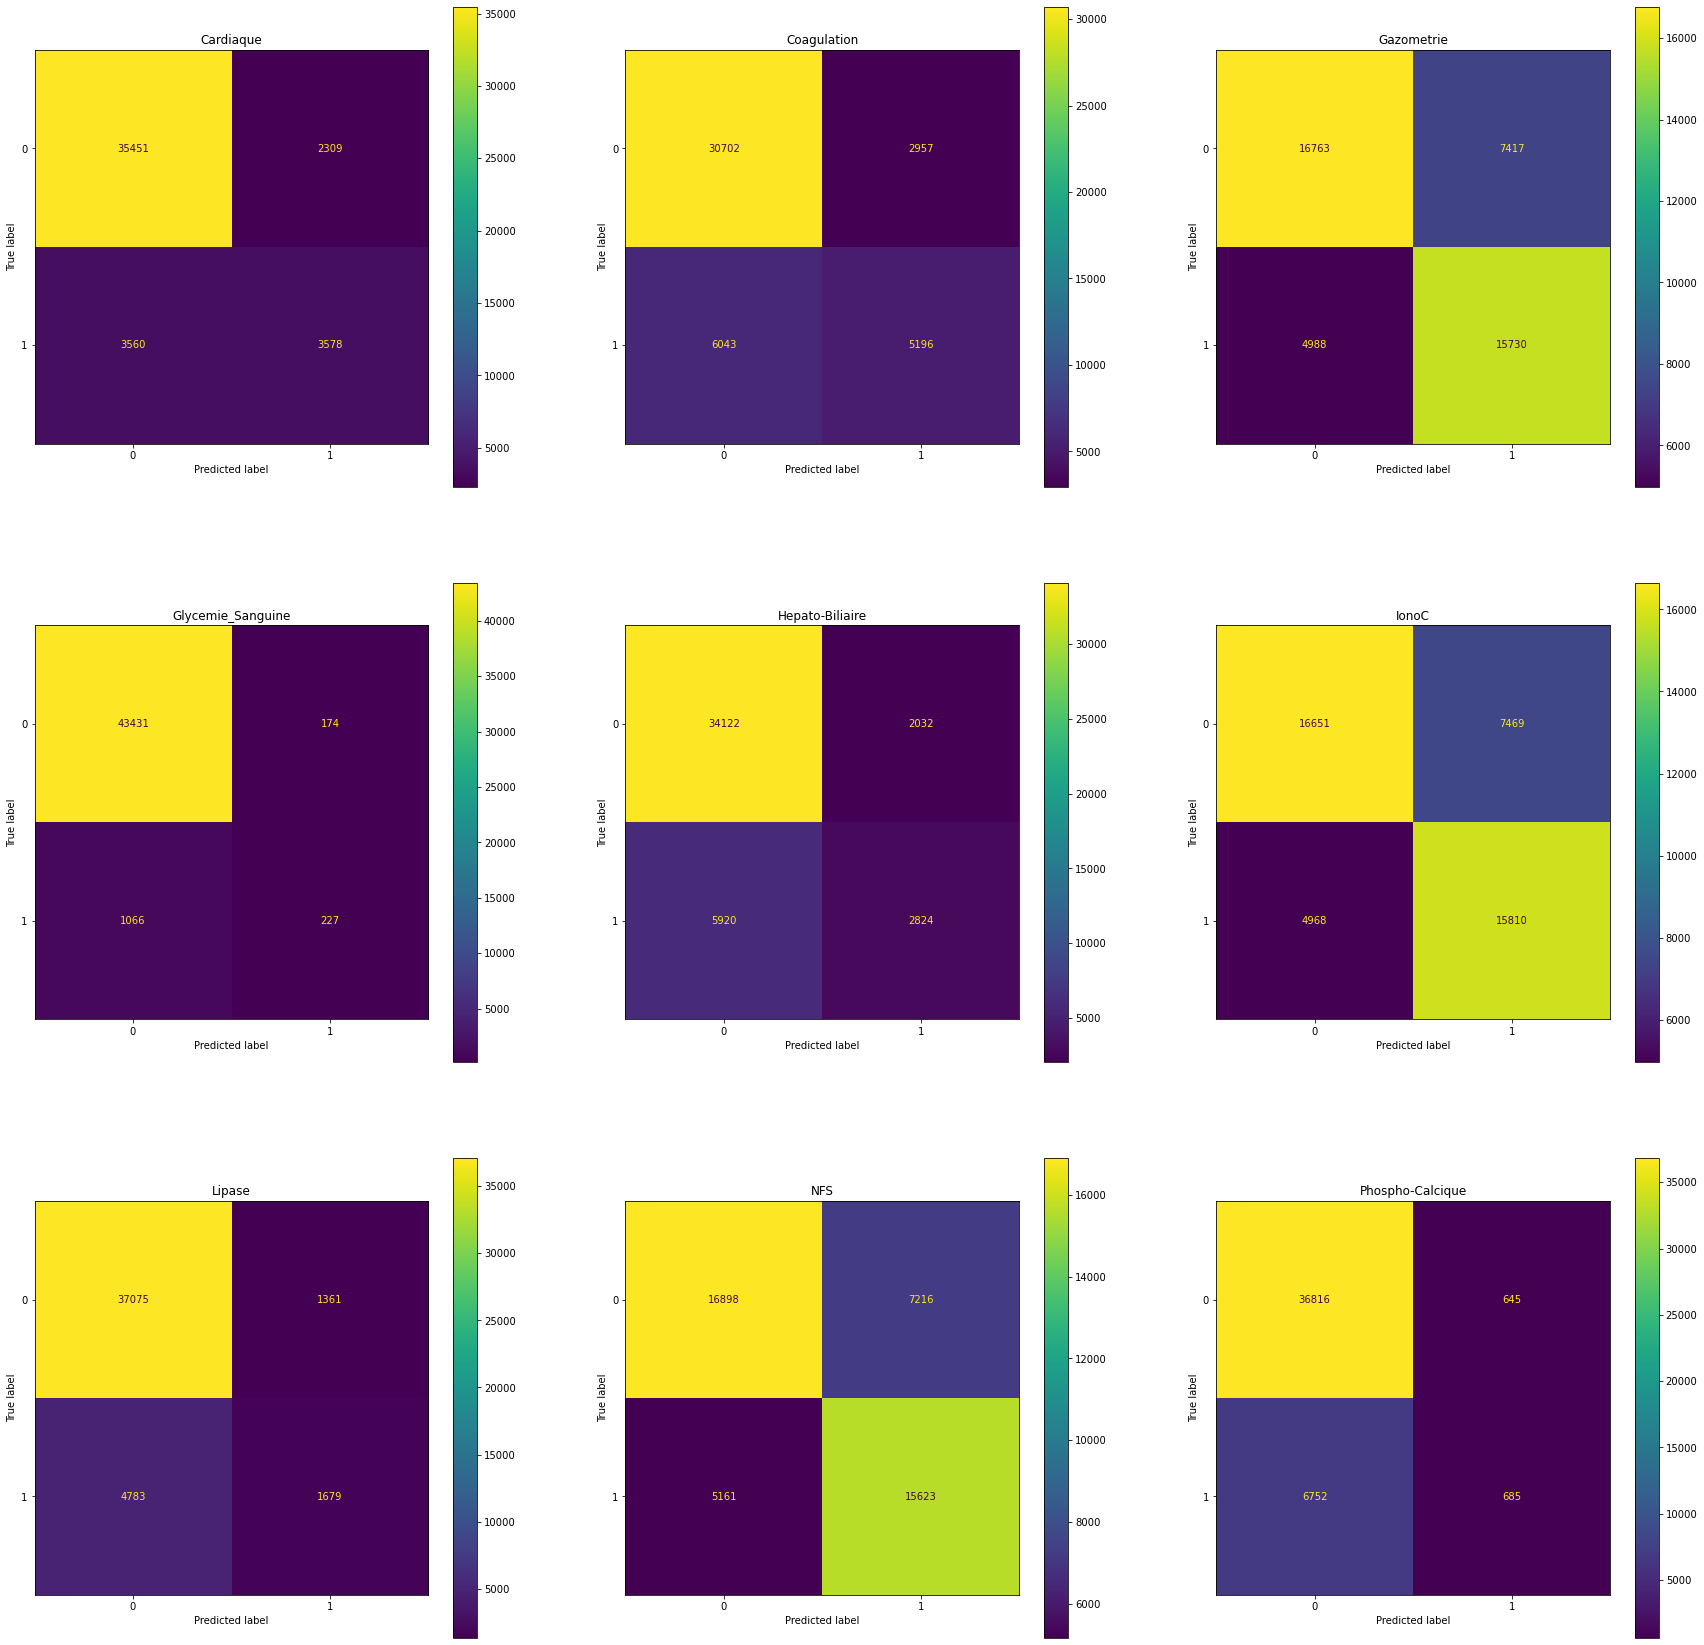

In [139]:
n_cols = 3
n_rows = len(titles) // n_cols + int((len(titles)%n_cols) != 0)

figs, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30,30))
axs_flatten = axs.flatten()

for i in range(len(titles)):
    cm_plot = ConfusionMatrixDisplay(confusion_matrix(y_true[:,i], y_hat[:,i]))
    cm_plot.plot(ax=axs_flatten[i])
    axs_flatten[i].set_title(titles[i])

plt.show()

In [140]:
pd.DataFrame.from_dict(
    dict(zip(titles, np.concatenate([
        precision_score(y_true, y_hat, average=None, zero_division=0).reshape(1,-1),
        recall_score(y_true, y_hat, average=None, zero_division=0).reshape(1,-1),
        f1_score(y_true, y_hat, average=None).reshape(1,-1)
    ], axis=0).T)),
    orient="index",
    columns=["precision","recall","f1_score"]
).round(2)

,precision,recall,f1_score
Cardiaque,0.61,0.50,0.55
Coagulation,0.64,0.46,0.54
Gazometrie,0.68,0.76,0.72
Glycemie_Sanguine,0.57,0.18,0.27
Hepato-Biliaire,0.58,0.32,0.42
IonoC,0.68,0.76,0.72
Lipase,0.55,0.26,0.35
NFS,0.68,0.75,0.72
Phospho-Calcique,0.52,0.09,0.16
